<a href="https://colab.research.google.com/github/hsnam95/my/blob/main/cluster_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import nltk
from bs4 import BeautifulSoup
import re
import os
import codecs
from sklearn import feature_extraction
!pip install mpld3
import mpld3
import requests

## preparing information

titles

In [ ]:
url = "https://raw.githubusercontent.com/brandomr/document_cluster/master/title_list.txt"
titles = requests.get(url).text.split('\n')
titles = titles[:100]
titles

genres

In [ ]:
url = "https://raw.githubusercontent.com/brandomr/document_cluster/master/genres_list.txt"
genres = requests.get(url).text.split('\n')
genres = genres[:100]
genres

synopses(wiki)

In [ ]:
url = "https://raw.githubusercontent.com/brandomr/document_cluster/master/synopses_list_wiki.txt"
synopses_wiki = requests.get(url).text.split('\n BREAKS HERE')
synopses_wiki = synopses_wiki[:100]
# cleaning
synopses_clean_wiki = []
for text in synopses_wiki:
    text = BeautifulSoup(text, 'html.parser').getText()
    #strips html formatting and converts to unicode
    synopses_clean_wiki.append(text)
synopses_wiki = synopses_clean_wiki
synopses_wiki

synopses(imdb)

In [ ]:
url = "https://raw.githubusercontent.com/brandomr/document_cluster/master/synopses_list_imdb.txt"
synopses_imdb = requests.get(url).text.split('\n BREAKS HERE')
synopses_imdb = synopses_imdb[:100]
# cleaning
synopses_clean_imdb = []
for text in synopses_imdb:
    text = BeautifulSoup(text, 'html.parser').getText()
    #strips html formatting and converts to unicode
    synopses_clean_imdb.append(text)
synopses_imdb = synopses_clean_imdb
synopses_imdb

combine wiki & imdb synopses

In [ ]:
synopses = []
for i in range(len(synopses_wiki)):
    item = synopses_wiki[i] + synopses_imdb[i]
    synopses.append(item)
synopses[0]


In [7]:
# generates index for each item in the corpora (in this case it's just rank) and I'll use this for scoring later
ranks = []
for i in range(0,len(titles)):
    ranks.append(i)

In [8]:
print(str(len(titles)) + ' titles')
print(str(len(synopses)) + ' synopses')
print(str(len(genres)) + ' genres')
print(str(len(ranks)) + ' ranks')

100 titles
100 synopses
100 genres
100 ranks


## Clean data

stop words

In [9]:
# load nltk's English stopwords as variable called 'stopwords'
nltk.download('stopwords')
stopwords = nltk.corpus.stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


stemming

In [10]:
# load nltk's SnowballStemmer as variabled 'stemmer'
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")

tokenize with stemming vs. tokenize only


In [11]:
# here I define a tokenizer and stemmer which returns the set of stems in the text that it is passed
def tokenize_and_stem(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems

def tokenize_only(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    return filtered_tokens

stemming/tokenizing and tokenizing functions to iterate over the list of synopses to create two vocabularies: one stemmed and one only tokenized. 

In [ ]:
nltk.download('punkt')
totalvocab_stemmed = []
totalvocab_tokenized = []
for i in synopses:
    allwords_stemmed = tokenize_and_stem(i)
    totalvocab_stemmed.extend(allwords_stemmed)
    
    allwords_tokenized = tokenize_only(i)
    totalvocab_tokenized.extend(allwords_tokenized)

In [ ]:
vocab_frame = pd.DataFrame({'words': totalvocab_tokenized}, index = totalvocab_stemmed)
vocab_frame

## K-means clustering

Tf-idf and document similarity

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=200000,
                                 min_df=0.2, stop_words='english',
                                 use_idf=True, tokenizer=tokenize_and_stem, ngram_range=(1,3))
tfidf_matrix = tfidf_vectorizer.fit_transform(synopses)
tfidf_matrix.shape

In [ ]:
terms = tfidf_vectorizer.get_feature_names_out()
terms

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
dist = 1 - cosine_similarity(tfidf_matrix)
dist

In [ ]:
from sklearn.cluster import KMeans
num_clusters = 5
km = KMeans(n_clusters=num_clusters)
km.fit(tfidf_matrix)
clusters = km.labels_.tolist()
clusters

In [ ]:
import pandas as pd
films = { 'title': titles, 'rank': ranks, 'synopsis': synopses, 'cluster': clusters, 'genre': genres }
frame = pd.DataFrame(films, index = [clusters] , columns = ['rank', 'title', 'cluster', 'genre'])
frame

In [ ]:
frame['cluster'].value_counts()

4    33
0    27
2    19
3    14
1     7
Name: cluster, dtype: int64

In [45]:
grouped = frame['rank'].groupby(frame['cluster'])
grouped.mean()

cluster
0    66.363636
1    43.687500
2    49.140000
3    59.428571
4    40.500000
Name: rank, dtype: float64

In [42]:
print("Top terms per cluster:")
print()
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
for i in range(num_clusters):
    print("Cluster %d words:" % i, end='')
    for ind in order_centroids[i, :6]:
        print(' %s' % vocab_frame.loc[terms[ind].split(' ')].values.tolist()[0][0].encode('utf-8', 'ignore'), end=',')
    print()
    print()
    print("Cluster %d titles:" % i, end='')
    for title in frame.loc[i]['title'].values.tolist():
        print(' %s,' % title, end='')
    print()
    print()

Top terms per cluster:

Cluster 0 words: b'car', b'new', b'train', b'new', b'york', b'apartments',

Cluster 0 titles: The Good, the Bad and the Ugly, Butch Cassidy and the Sundance Kid, The Apartment, High Noon, Goodfellas, The French Connection, It Happened One Night, Rain Man, Network, American Graffiti, Taxi Driver,

Cluster 1 words: b'family', b'new', b'children', b'war', b'marries', b'love',

Cluster 1 titles: The Godfather, Raging Bull, Gone with the Wind, Citizen Kane, The Godfather: Part II, The Sound of Music, A Streetcar Named Desire, The Best Years of Our Lives, Doctor Zhivago, Midnight Cowboy, Mr. Smith Goes to Washington, Annie Hall, Out of Africa, Terms of Endearment, Giant, Wuthering Heights,

Cluster 2 words: b'police', b'killed', b'friends', b'house', b"n't", b'asks',

Cluster 2 titles: The Shawshank Redemption, Casablanca, One Flew Over the Cuckoo's Nest, The Wizard of Oz, Titanic, Psycho, Sunset Blvd., Vertigo, On the Waterfront, Forrest Gump, West Side Story, Star W

Multidimensional scaling (시각화를 위한 차원 축소 563 -> 2)

In [ ]:
import os
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.manifold import MDS

mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)
pos = mds.fit_transform(dist)  # shape (n_components, n_samples)
xs, ys = pos[:, 0], pos[:, 1]

In [49]:
#set up colors per clusters using a dict
cluster_colors = {0: '#1b9e77', 1: '#d95f02', 2: '#7570b3', 3: '#e7298a', 4: '#66a61e'}

#set up cluster names using a dict
cluster_names = {0: 'Family, home, war', 
                 1: 'Police, killed, murders', 
                 2: 'Father, New York, brothers', 
                 3: 'Dance, singing, love', 
                 4: 'Killed, soldiers, captain'}

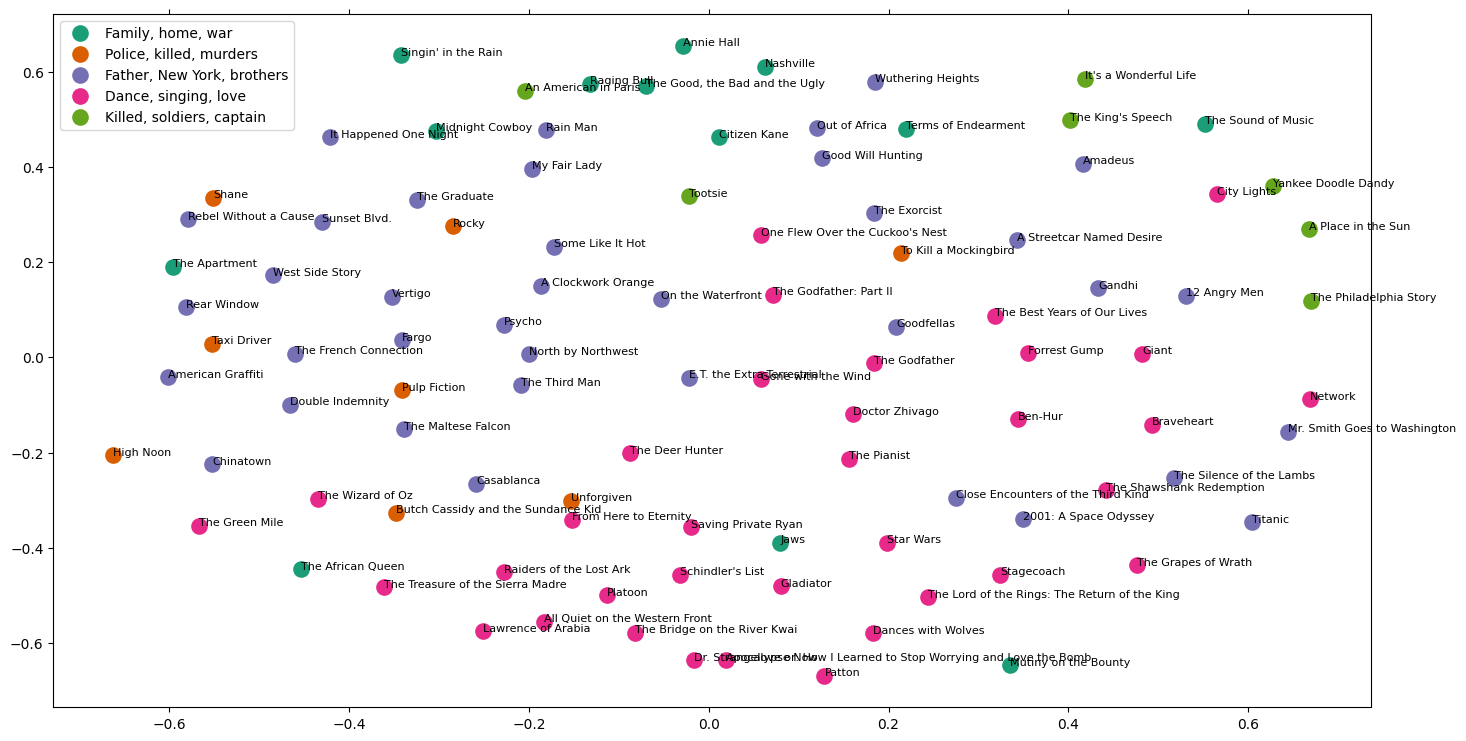

In [50]:
#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=titles)) 

#group by cluster
groups = df.groupby('label')

# set up plot
fig, ax = plt.subplots(figsize=(17, 9)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, label=cluster_names[name], color=cluster_colors[name], mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='off')
    
ax.legend(numpoints=1)  #show legend with only 1 point

#add label in x,y position with the label as the film title
for i in range(len(df)):
    ax.text(df.loc[i]['x'], df.loc[i]['y'], df.loc[i]['title'], size=8)
    
plt.show() #show the plot

##Hierarchical document clustering(dendrogram)

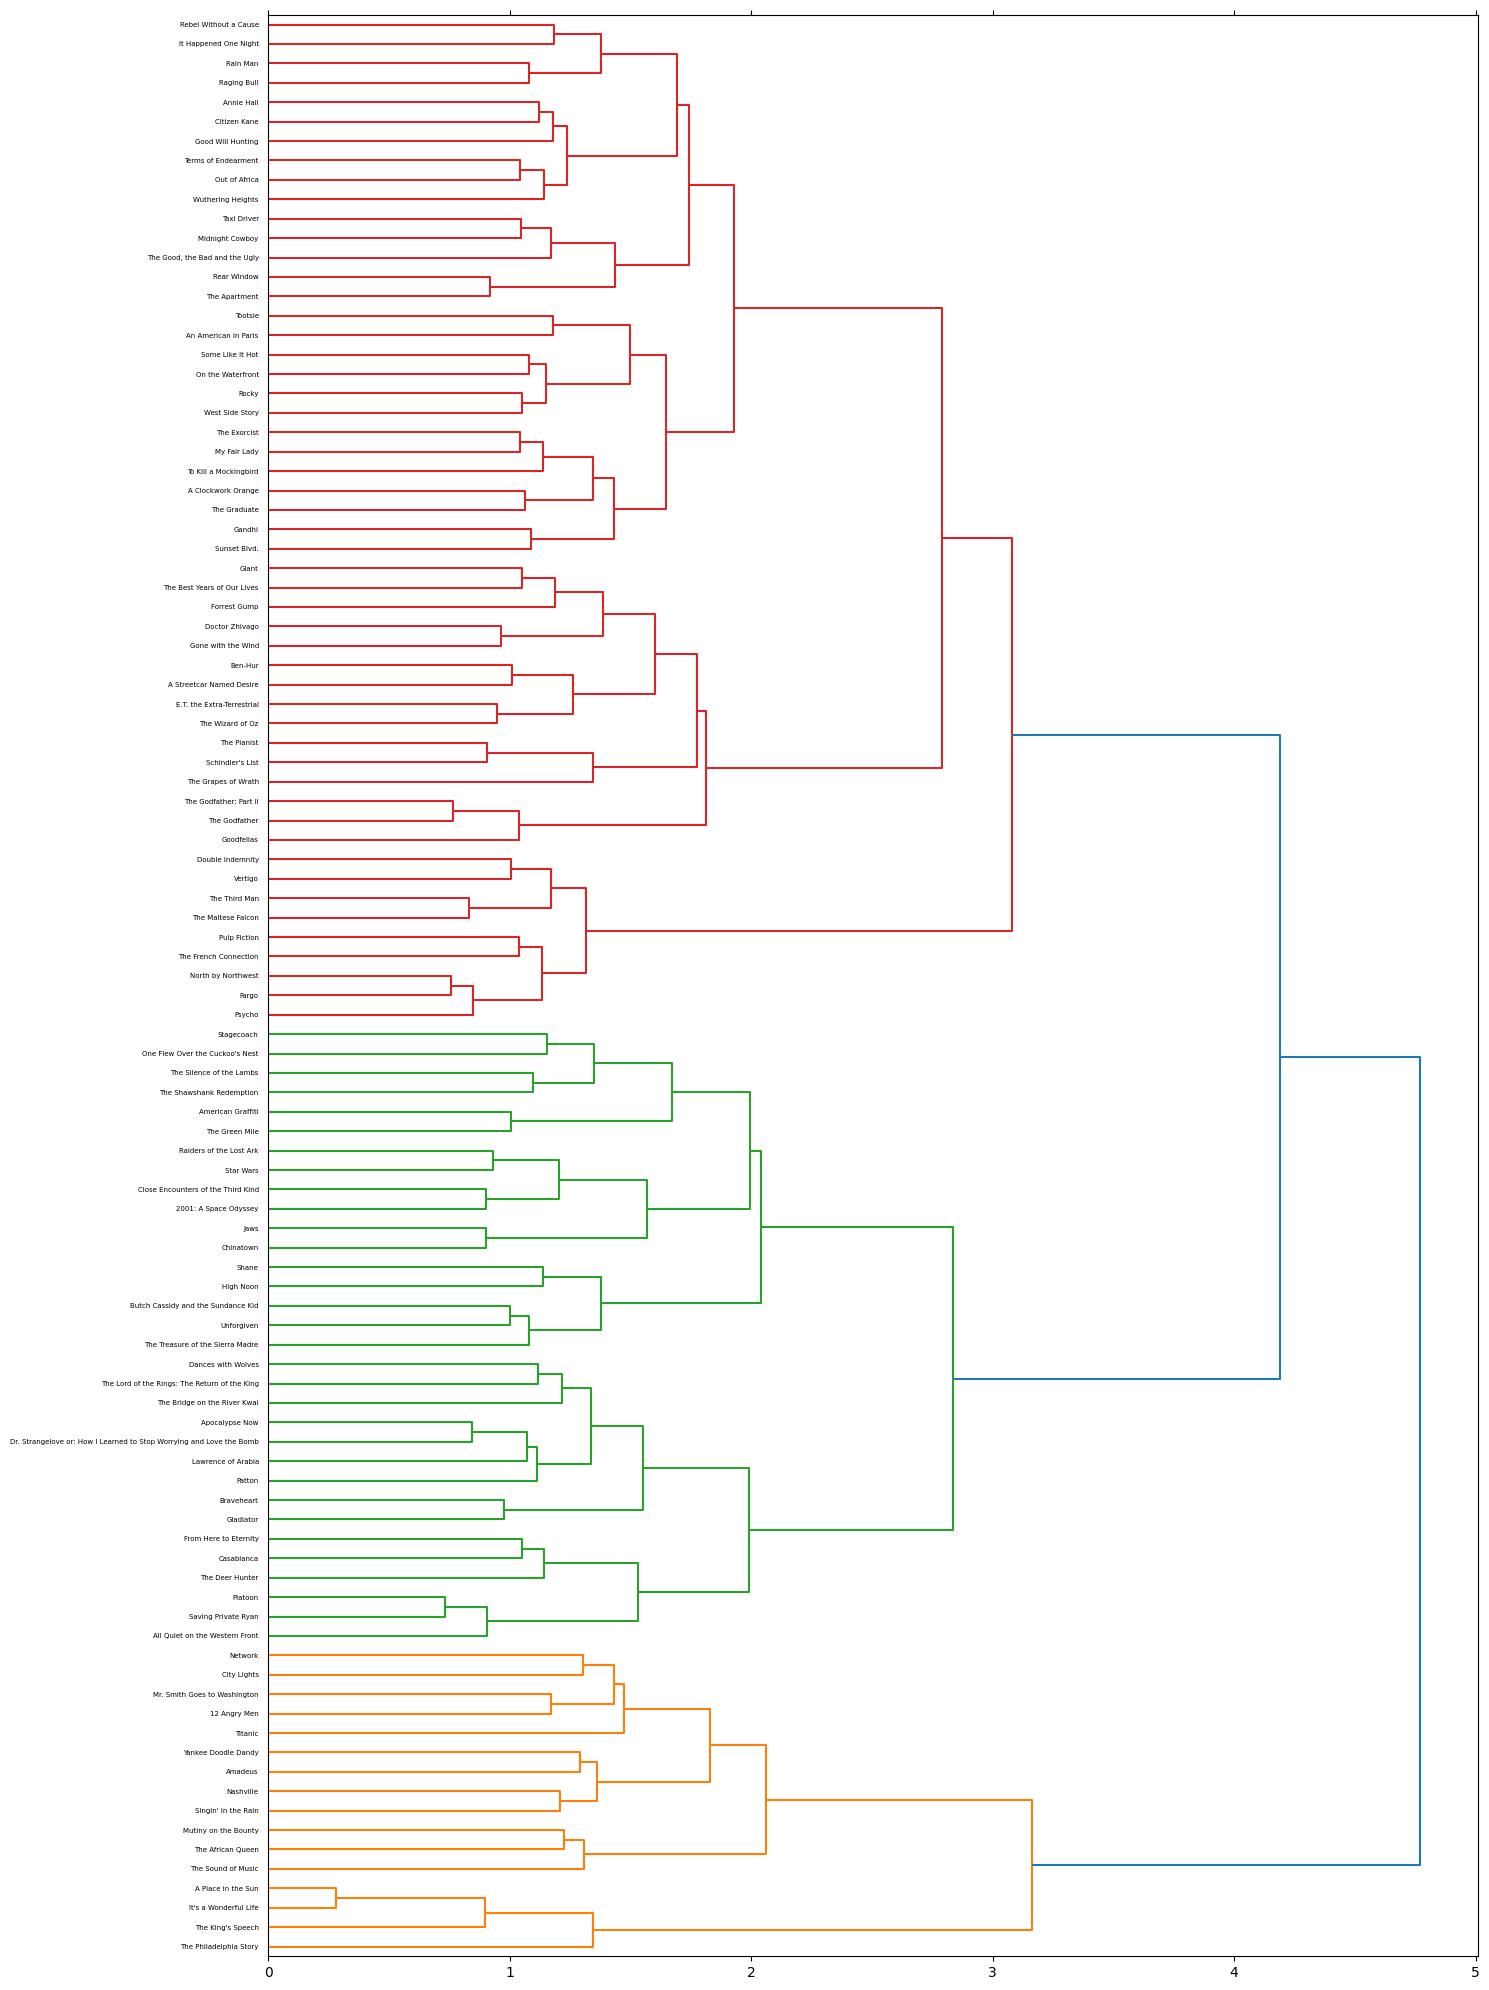

In [51]:
from scipy.cluster.hierarchy import ward, dendrogram
linkage_matrix = ward(dist) #define the linkage_matrix using ward clustering pre-computed distances
fig, ax = plt.subplots(figsize=(15, 20)) # set size
ax = dendrogram(linkage_matrix, orientation="right", labels=titles);
plt.tick_params(\
    axis= 'x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off')
plt.tight_layout() #show plot with tight layout